<a href="https://colab.research.google.com/github/supernova276/rural_water_stress_analysis/blob/main/Rural_Water_Stress_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rural Water Stress Management System
### Predictive Analytics and Decision Support

This notebook implements a complete machine learning pipeline to predict village-level water stress using groundwater, rainfall, and infrastructure data.

**Key Features:**
1. **Synthetic Data Generation**: Reproduces the 2,000-village dataset used in the analysis.
2. **Feature Engineering**: Calculates per-capita availability and infrastructure risk scores.
3. **Predictive Modeling**: Uses Gradient Boosting to estimate the probability of water shortage.
4. **Visualizations**: ROC curves, Confusion Matrices, and District-level heatmaps.
5. **Actionable Outputs**: Generates a prioritized intervention list (CSV) and administrative alerts (JSON).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Set visual style
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## 1. Dataset Generation
Generating the synthetic dataset as per the provided schema.

In [2]:
n = 2000

village_data = pd.DataFrame({
    'village_id': range(1, n+1),
    'district': np.random.choice(['District_A','District_B','District_C','District_D','District_E'], n),
    'population': np.random.randint(500, 6000, n),
    'primary_source_type': np.random.choice(['handpump','borewell','mini_piped','tank'], n)
})

# Groundwater indicators
village_data['depth_to_water_table'] = np.random.uniform(5, 45, n)
village_data['groundwater_decline_rate'] = np.random.uniform(-0.3, 1.8, n)

# Rainfall indicators
village_data['rainfall_mm_last_30_days'] = np.random.uniform(0, 300, n)
village_data['rainfall_deficit_index'] = np.random.uniform(-60, 40, n)

# Infrastructure indicators
village_data['days_since_last_repair'] = np.random.randint(0, 400, n)
village_data['breakdown_count_last_year'] = np.random.randint(0, 10, n)
village_data['complaint_growth_rate'] = np.random.uniform(0, 1.5, n)

# Target variable logic (Rule-based for training)
village_data['water_stress_flag'] = (
    (village_data['groundwater_decline_rate'] > 1.0) |
    (village_data['rainfall_deficit_index'] < -25) |
    (village_data['days_since_last_repair'] > 250)
).astype(int)

village_data.to_csv('rural_water_stress_dataset.csv', index=False)
print("Dataset generated and saved as 'rural_water_stress_dataset.csv'.")
village_data.head()

Dataset generated and saved as 'rural_water_stress_dataset.csv'.


,village_id,district,population,primary_source_type,depth_to_water_table,groundwater_decline_rate,rainfall_mm_last_30_days,rainfall_deficit_index,days_since_last_repair,breakdown_count_last_year,complaint_growth_rate,water_stress_flag
0,1,District_D,1487,mini_piped,20.124031,1.542350,219.124880,3.302891,317,5,0.577284,1
1,2,District_E,2046,borewell,10.735815,0.309760,159.862930,-2.171138,241,4,1.164175,0
2,3,District_C,1149,handpump,5.735446,-0.127777,279.307798,-34.075986,359,1,0.647478,1
3,4,District_E,1468,borewell,23.562668,0.326836,285.432792,30.882403,328,8,0.498342,1
4,5,District_E,3137,handpump,42.722476,1.111960,108.439599,-57.882764,332,5,0.616984,1


## 2. Feature Engineering
Calculating derived indicators to improve model performance.

In [3]:
def engineer_features(data):
    df = data.copy()
    # Per capita availability proxy
    df['per_capita_rainfall'] = df['rainfall_mm_last_30_days'] / (df['population'] + 1)

    # Infrastructure stress score
    df['infra_risk_index'] = (df['breakdown_count_last_year'] * df['days_since_last_repair']) / 365

    # Groundwater trend impact
    df['gw_trend_impact'] = df['depth_to_water_table'] * df['groundwater_decline_rate']

    return df

processed_df = engineer_features(village_data)
processed_df.head()

,village_id,district,population,primary_source_type,depth_to_water_table,groundwater_decline_rate,rainfall_mm_last_30_days,rainfall_deficit_index,days_since_last_repair,breakdown_count_last_year,complaint_growth_rate,water_stress_flag,per_capita_rainfall,infra_risk_index,gw_trend_impact
0,1,District_D,1487,mini_piped,20.124031,1.542350,219.124880,3.302891,317,5,0.577284,1,0.147261,4.342466,31.038308
1,2,District_E,2046,borewell,10.735815,0.309760,159.862930,-2.171138,241,4,1.164175,0,0.078096,2.641096,3.325526
2,3,District_C,1149,handpump,5.735446,-0.127777,279.307798,-34.075986,359,1,0.647478,1,0.242876,0.983562,-0.732861
3,4,District_E,1468,borewell,23.562668,0.326836,285.432792,30.882403,328,8,0.498342,1,0.194304,7.189041,7.701116
4,5,District_E,3137,handpump,42.722476,1.111960,108.439599,-57.882764,332,5,0.616984,1,0.034557,4.547945,47.505680


## 3. Modeling and Evaluation
Building a Gradient Boosting pipeline.

In [4]:
# Preprocessing setup
X = processed_df.drop(['village_id', 'water_stress_flag'], axis=1)
y = processed_df['water_stress_flag']

categorical_cols = ['district', 'primary_source_type']
numerical_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Gradient Boosting Classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

# Metrics
y_probs = model.predict_proba(X_test)[:, 1]
y_preds = model.predict(X_test)
print(f"Validation ROC-AUC: {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_preds))

Validation ROC-AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       299

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



## 4. Visualizations
Key performance and risk analysis plots.

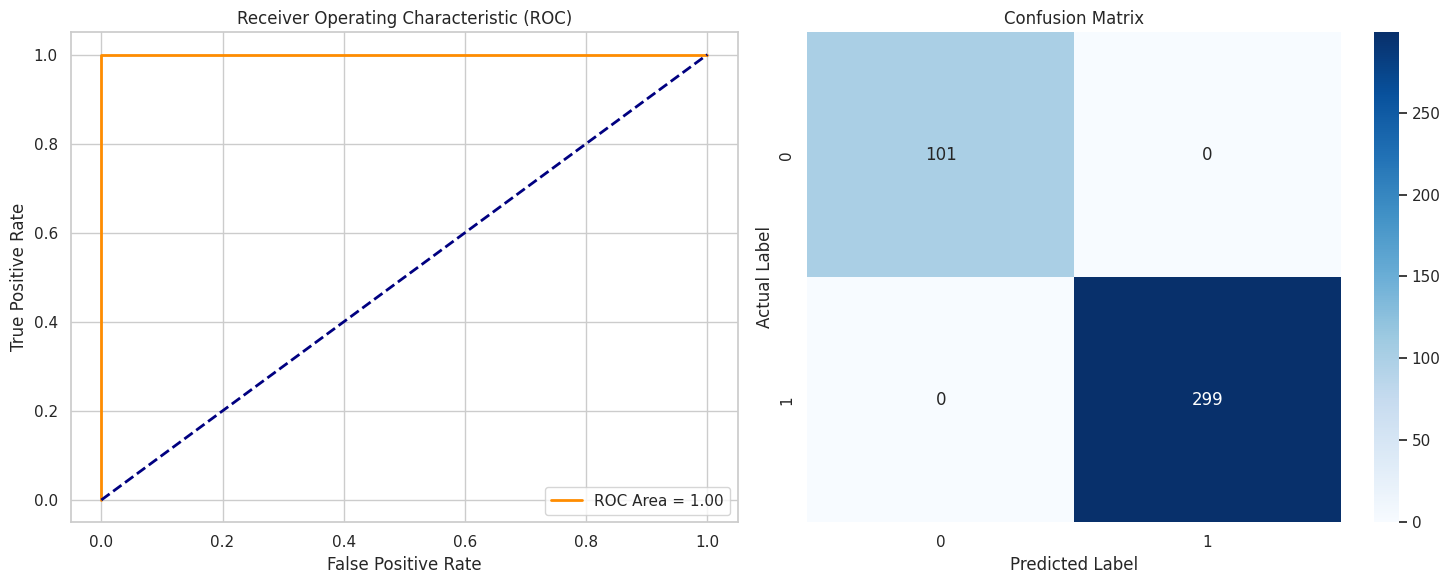

/tmp/ipython-input-3585705402.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=district_risk, x='district', y='predicted_risk_prob', palette='magma')


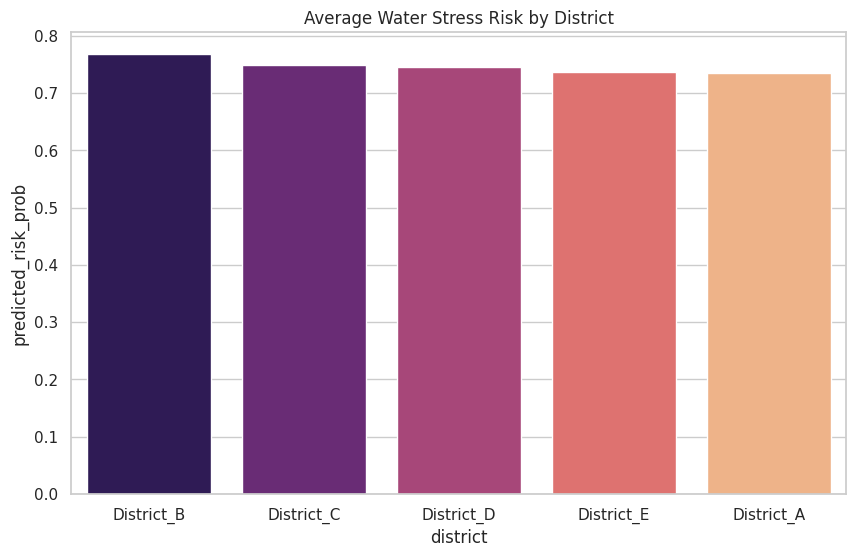

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Area = {roc_auc_score(y_test, y_probs):.2f}')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Receiver Operating Characteristic (ROC)')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 3. District-level Risk Probability
processed_df['predicted_risk_prob'] = model.predict_proba(X)[:, 1]
plt.figure(figsize=(10, 6))
district_risk = processed_df.groupby('district')['predicted_risk_prob'].mean().sort_values(ascending=False).reset_index()
sns.barplot(data=district_risk, x='district', y='predicted_risk_prob', palette='magma')
plt.title('Average Water Stress Risk by District')
plt.show()

## 5. Prioritization & Exports
Creating the actionable intervention lists.

In [6]:
processed_df['risk_category'] = pd.cut(processed_df['predicted_risk_prob'],
                                       bins=[-0.01, 0.3, 0.7, 1.0],
                                       labels=['Low', 'Medium', 'High'])

def suggest_action(row):
    if row['risk_category'] == 'High':
        return 'Immediate Tanker Preparation & Infrastructure Repair'
    elif row['risk_category'] == 'Medium':
        return 'Preventive Maintenance & Community Awareness'
    return 'Routine Monitoring'

processed_df['suggested_action'] = processed_df.apply(suggest_action, axis=1)

# Save Ranked CSV
ranked_villages = processed_df[['village_id', 'district', 'predicted_risk_prob', 'risk_category', 'suggested_action']].sort_values('predicted_risk_prob', ascending=False)
ranked_villages.to_csv('village_intervention_ranking.csv', index=False)

# Save Alert JSON
alerts = ranked_villages[ranked_villages['risk_category'] == 'High'].head(50).to_dict(orient='records')
with open('water_stress_alerts.json', 'w') as f:
    json.dump(alerts, f, indent=4)

print("Final intervention list and alerts exported successfully.")

Final intervention list and alerts exported successfully.
